In [20]:
import torch
import torch.distributed
import torch.nn as nn
import torchvision.transforms as transforms
from torchsummary import summary
import xarray as xr
import numpy as np
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time

In [2]:
torch.cuda.device_count()

2

In [3]:
# Decide which device we want to run on
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Set up generator

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        
        self.z_dim = z_dim
        
        self.gen = nn.Sequential(
            
            self.get_generator_block(z_dim, 
                                     hidden_dim * 4,
                                     kernel_size=2, 
                                     stride=2),
            
            self.get_generator_block(hidden_dim * 4, 
                                     hidden_dim * 2,
                                     kernel_size=2,
                                     stride = 2),
            self.get_generator_block(hidden_dim * 2, 
                                     hidden_dim * 2,
                                     kernel_size=2,
                                     stride = 2),
            self.get_generator_block(hidden_dim * 2,
                                     hidden_dim ,
                                     kernel_size=2,
                                     stride = 2,
                                    ),
            
            self.get_generator_final_block(hidden_dim,
                                           im_chan,
                                           kernel_size=2,
                                           stride=2)
            

        )
        
        
    def get_generator_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channel),
                nn.ReLU(inplace=True),
        )
    
    
    def get_generator_final_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return  nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.Tanh()
            )
    
    
    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)
    
    
    
summary(Generator(64, im_chan=2).to(device), (8,8))
print(Generator(64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 2, 2]          65,792
       BatchNorm2d-2            [-1, 256, 2, 2]             512
              ReLU-3            [-1, 256, 2, 2]               0
   ConvTranspose2d-4            [-1, 128, 4, 4]         131,200
       BatchNorm2d-5            [-1, 128, 4, 4]             256
              ReLU-6            [-1, 128, 4, 4]               0
   ConvTranspose2d-7            [-1, 128, 8, 8]          65,664
       BatchNorm2d-8            [-1, 128, 8, 8]             256
              ReLU-9            [-1, 128, 8, 8]               0
  ConvTranspose2d-10           [-1, 64, 16, 16]          32,832
      BatchNorm2d-11           [-1, 64, 16, 16]             128
             ReLU-12           [-1, 64, 16, 16]               0
  ConvTranspose2d-13            [-1, 2, 32, 32]             514
             Tanh-14            [-1, 2,

## Set up Critic 

In [5]:
class Critic(nn.Module):

    def __init__(self, im_chan=1, hidden_dim=16):
        super(Critic, self).__init__()
        self.disc = nn.Sequential(
            self.get_critic_block(im_chan,
                                         hidden_dim * 4,
                                         kernel_size=4,
                                         stride=2),
            
            self.get_critic_block(hidden_dim * 4,
                                         hidden_dim * 8,
                                         kernel_size=4,
                                         stride=2,),
            
            self.get_critic_final_block(hidden_dim * 8,
                                               1,
                                               kernel_size=4,
                                               stride=2,),

        )

        
    def get_critic_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channel),
                nn.LeakyReLU(0.2, inplace=True)
        )
    
    
    def get_critic_final_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return  nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride, padding),
            )
    
    def forward(self, image):
        return self.disc(image)
    
summary(Critic().to(device) , (1,32,32))
print(Critic())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 15, 15]           1,088
       BatchNorm2d-2           [-1, 64, 15, 15]             128
         LeakyReLU-3           [-1, 64, 15, 15]               0
            Conv2d-4            [-1, 128, 6, 6]         131,200
       BatchNorm2d-5            [-1, 128, 6, 6]             256
         LeakyReLU-6            [-1, 128, 6, 6]               0
            Conv2d-7              [-1, 1, 2, 2]           2,049
Total params: 134,721
Trainable params: 134,721
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.44
Params size (MB): 0.51
Estimated Total Size (MB): 0.95
----------------------------------------------------------------
Critic(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2,

In [6]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples,z_dim, z_dim, device=device)

# Preprocess Derecho radar data

Downscaling of near-surface winds from radar. Workflow:

Take 4 corners NW, NE, SW, SE of radar 32 x 32 grid points in size (32 km by 32 km). Stack, and normalize data by 50 m/s to scale between 0,1.

In [296]:
date = '2009'
radar = 'KDMX'
grids_KDMX = xr.open_mfdataset(
    f'/lcrc/group/earthscience/rjackson/Earnest/wind_product_b1/EARNEST.wind.{date}*.{radar}.b1.nc',
    concat_dim="time", combine="nested")
grids_KDMX['spd'] = grids_KDMX['spd'] * grids_KDMX['correction_factor']

OSError: no files to open

In [295]:
spd_sector1 = grids_KDMX['spd'].isel(z=0).sel(x=slice(-31000., 0.), y=slice(-31000., 0))
spd_sector2 = grids_KDMX['spd'].isel(z=0).sel(x=slice(0., 31000.), y=slice(-31000., 0))
spd_sector3 = grids_KDMX['spd'].isel(z=0).sel(x=slice(-31000., 0.), y=slice(0, 31000.))
spd_sector4 = grids_KDMX['spd'].isel(z=0).sel(x=slice(0., 31000.), y=slice(0., 31000.))
spd_sector1_coarse = spd_sector1.coarsen(x=4, y=4).mean()
spd_sector2_coarse = spd_sector2.coarsen(x=4, y=4).mean()
spd_sector3_coarse = spd_sector3.coarsen(x=4, y=4).mean()
spd_sector4_coarse = spd_sector4.coarsen(x=4, y=4).mean()
out_dataset = {'spd1': (['time', 'y', 'x'], spd_sector1.values),
               'spd2': (['time', 'y', 'x'], spd_sector2.values),
               'spd3': (['time', 'y', 'x'], spd_sector3.values),
               'spd4': (['time', 'y', 'x'], spd_sector4.values),
               'spd1_c': (['time', 'yc', 'xc'], spd_sector1_coarse.values),
               'spd2_c': (['time', 'yc', 'xc'], spd_sector2_coarse.values),
               'spd3_c': (['time', 'yc', 'xc'], spd_sector3_coarse.values),
               'spd4_c': (['time', 'yc', 'xc'], spd_sector4_coarse.values)}
out_dataset = xr.Dataset(out_dataset)
out_dataset.to_netcdf(
    f'/lcrc/group/earthscience/rjackson/Earnest/wind_quicklooks/post_processed_downscaling/{radar}_{date}.nc')

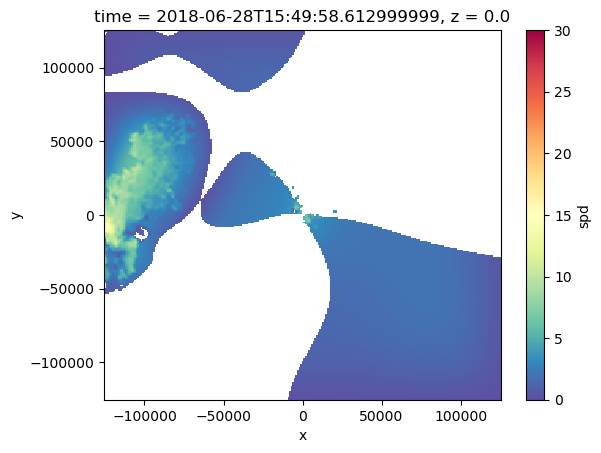

In [282]:
grids_KDMX['spd'].isel(time=20, z=0).plot(cmap='Spectral_r', vmin=0, vmax=30)

In [64]:
grids_KDMX['spd'].isel(time=24, z=0).sel(x=slice(-31000., 0.), y=slice(-31000., 0)).coarsen(x=4, y=4).mean().shape

(8, 8)

In [58]:
grids_KDMX['spd'].isel(time=24, z=0).sel(x=slice(-31000., 0.), y=slice(-31000., 0)).values.shape

(32, 32)

In [12]:
post_processed = xr.open_mfdataset(
    '/lcrc/group/earthscience/rjackson/Earnest/wind_quicklooks/post_processed_downscaling/KDVN*.nc',
    concat_dim="time", combine="nested")
post_processed_KDMX = xr.open_mfdataset(
    '/lcrc/group/earthscience/rjackson/Earnest/wind_quicklooks/post_processed_downscaling/KDMX*.nc',
    concat_dim="time", combine="nested")
post_processed

<xarray.Dataset> Size: 84MB
Dimensions:  (time: 2413, y: 32, x: 32, yc: 8, xc: 8)
Dimensions without coordinates: time, y, x, yc, xc
Data variables:
    spd1     (time, y, x) float64 20MB dask.array<chunksize=(79, 32, 32), meta=np.ndarray>
    spd2     (time, y, x) float64 20MB dask.array<chunksize=(79, 32, 32), meta=np.ndarray>
    spd3     (time, y, x) float64 20MB dask.array<chunksize=(79, 32, 32), meta=np.ndarray>
    spd4     (time, y, x) float64 20MB dask.array<chunksize=(79, 32, 32), meta=np.ndarray>
    spd1_c   (time, yc, xc) float64 1MB dask.array<chunksize=(79, 8, 8), meta=np.ndarray>
    spd2_c   (time, yc, xc) float64 1MB dask.array<chunksize=(79, 8, 8), meta=np.ndarray>
    spd3_c   (time, yc, xc) float64 1MB dask.array<chunksize=(79, 8, 8), meta=np.ndarray>
    spd4_c   (time, yc, xc) float64 1MB dask.array<chunksize=(79, 8, 8), meta=np.ndarray>

In [13]:
spd_fine = np.concatenate([post_processed['spd1'].values, 
            post_processed['spd2'].values,
            post_processed['spd3'].values,
            post_processed['spd4'].values,
            post_processed_KDMX['spd1'].values, 
            post_processed_KDMX['spd2'].values,
            post_processed_KDMX['spd3'].values,
            post_processed_KDMX['spd4'].values], axis=0)
spd_fine.shape
spd_fine_mask = np.where(~np.isfinite(spd_fine), 0, 1) 
spd_fine_gen = np.where(~np.isfinite(spd_fine), 0, spd_fine)
#spd_fine_gen = np.stack([spd_fine_gen, spd_fine_mask], axis=1)
spd_coarse = np.concatenate([post_processed['spd1_c'].values, 
            post_processed['spd2_c'].values,
            post_processed['spd3_c'].values,
            post_processed['spd4_c'].values,
            post_processed_KDMX['spd1_c'].values, 
            post_processed_KDMX['spd2_c'].values,
            post_processed_KDMX['spd3_c'].values,
            post_processed_KDMX['spd4_c'].values], axis=0)
spd_coarse_mask = np.where(~np.isfinite(spd_coarse), 0, 1)
spd_coarse_gen = np.where(~np.isfinite(spd_coarse), 0, spd_coarse)
spd_coarse_gen = np.stack([spd_coarse_gen, spd_coarse_mask], axis=1)
#spd_coarse = spd_coarse.reshape((spd_coarse.shape[0], spd_coarse.shape[1]*spd_coarse.shape[2]))
spd_coarse_gen.shape

(16720, 2, 8, 8)

In [9]:
spd_coarse_gen.max()

np.float64(56.68326682608673)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(
    spd_coarse_gen, spd_fine_gen, random_state=666)
# Normalize data
wind_max = spd_fine_gen.max()
x_test = x_test/wind_max
y_test = y_test/wind_max
x_train = x_train/wind_max
y_train = y_train/wind_max

# One channel 
y_test = y_test[:, np.newaxis, :, :]
y_train = y_train[:, np.newaxis, :, :]
# Convert to Tensor
x_test = torch.Tensor(x_test)
y_test = torch.Tensor(y_test)
x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)

In [11]:
x_test.shape

torch.Size([4180, 2, 8, 8])

In [15]:
z_dim = 128            # Input space dimension
batch_size = 128       

fixed_noise = get_noise(batch_size, z_dim, device=device)

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

dataloader_test = DataLoader(
    TensorDataset(x_train, y_train), batch_size=64, shuffle=True)

## Optimizer

In [16]:
lr = 0.0002
beta_1 = 0.5 
beta_2 = 0.999

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

        
gen = Generator(z_dim, im_chan=1).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))

crit  = Critic().to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

gen = gen.apply(weights_init)
crit = crit.apply(weights_init)    

In [17]:
def gradient_penalty(gradient):
    gradient = gradient.view(len(gradient), -1)

    gradient_norm = gradient.norm(2, dim=1)
    
    penalty = torch.mean((gradient_norm - 1)**2)
    return penalty
    
def get_gen_loss(crit_fake_pred):
    gen_loss = -1. * torch.mean(crit_fake_pred)
    return gen_loss

def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp
    return crit_loss

In [18]:
def get_gradient(crit, real, fake, epsilon):
    mixed_images = real * epsilon + fake * (1 - epsilon)

    mixed_scores = crit(mixed_images)
    
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
        
    )[0]
    return gradient

In [ ]:
n_epochs = 400
cur_step = 0
total_steps = 0
start_time = time.time()
cur_step = 0

generator_losses = []
critic_losses = []

C_mean_losses = []
G_mean_losses = []

c_lambda = 10
crit_repeats = 5
display_step = 50

for epoch in range(200, n_epochs):
    cur_step = 0
    start = time.time()
    gen.train()
    for coarse, fine in dataloader_test:
        cur_batch_size = len(coarse)
        coarse = coarse.to(device)
        fine = fine.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            
            ### Put in 4 channels of noise, one channel of real values
            fake = gen(coarse)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = fine

            epsilon = torch.rand(len(fine), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, fine, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward()
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_2 = gen(coarse)
        crit_fake_pred = crit(fake_2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gr_loss = 100*torch.nn.functional.l1_loss(fake_2, fine)
        gen_loss = gen_loss + gr_loss
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]
        
        cur_step += 1
        total_steps += 1
        
        print_val = f"Epoch: {epoch}/{n_epochs} Steps:{cur_step}/{len(dataloader_test)}\t"
        print_val += f"Epoch_Run_Time: {(time.time()-start):.6f}\t"
        print_val += f"Loss_C : {mean_iteration_critic_loss:.6f}\t"
        print_val += f"Loss_G : {gen_loss:.6f}\t" 
    if epoch % 10 == 0 and epoch > 0:
        torch.save(gen, f'generator{epoch}.pth')
        torch.save(crit, f'critic{epoch}.pth')
        #plot_image(1580, epoch)
    print(print_val, end='\r',flush = True)
    #plot_image(3000)

Epoch: 203/400 Steps:196/196	Epoch_Run_Time: 12.680781	Loss_C : -2338287.800000	Loss_G : 2338358.250000	

In [28]:
out_png_path = '/lcrc/group/earthscience/rjackson/Earnest/WGAN_tests/'
def plot_image(image_no, epoch_no):
    gen_image = gen(x_train[image_no:image_no+1, :, :, :].to(device)).cpu().detach().numpy()
    fig, ax = plt.subplots(3, 1, figsize=(5,10))
    coarse = x_train[image_no, 0, :, :]
    coarse = np.where(coarse > 0, coarse, np.nan)*wind_max
    c = ax[0].pcolormesh(coarse,
                         vmin=0, vmax=30, cmap='Spectral_r')
    plt.colorbar(c)
    ax[0].set_title('4 km data')
    fine = y_train[image_no, 0, :, :]
    fine = np.where(fine > 0, fine, np.nan)*wind_max
    c = ax[1].pcolormesh(fine,
                         vmin=0, vmax=30, cmap='Spectral_r')
    plt.colorbar(c)
    ax[1].set_title('1 km data')
    gen_image = np.where(gen_image[0, 0, :, :] > 0, gen_image[0, 0, :, :], np.nan) * wind_max
    c = ax[2].pcolormesh(gen_image,
                         vmin=0, vmax=30, cmap='Spectral_r')
    plt.colorbar(c)
    ax[2].set_title('Generator output')
    fig.savefig(os.path.join(out_png_path, f'comparison{epoch_no}.png'), bbox_inches='tight')

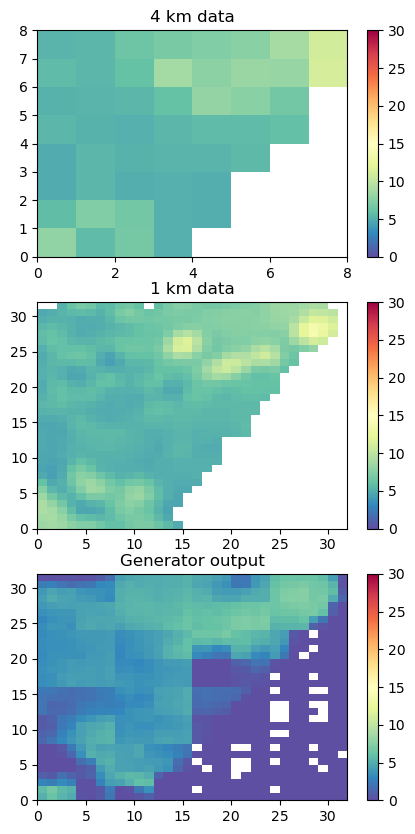

In [29]:
plot_image(1580, 200)

In [30]:
torch.save(gen, 'generator.pth')
torch.save(crit, 'critic.pth')

In [31]:
def compare_distributions():
    gen_image = gen(x_train[:, :, :, :].to(device)).cpu().detach().numpy()
    coarse = x_train[:, 0, :, :].squeeze()
    coarse = np.where(coarse > 0, coarse, np.nan)*wind_max
    fine = y_train[:, 0, :, :].squeeze()
    fine = np.where(fine > 0, fine, np.nan)*wind_max
    gen_image = np.where(gen_image[:, 0, :, :].squeeze() > 0.001, gen_image[:, 0, :, :].squeeze(), np.nan) * wind_max
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    bins = np.arange(0, 40, 1.)
    plt.hist(coarse.flatten(), bins=bins, histtype='step', density=True,linewidth=2, color='k', label='4 km grid')
    plt.hist(fine.flatten(), bins=bins, histtype='step', density=True,linewidth=2, color='r', label='1 km grid')
    plt.hist(gen_image.flatten(), bins=bins, histtype='step', density=True, linewidth=2, color='b', label='Generator')
    plt.legend()
    plt.yscale('log')
    plt.ylabel('p.d.f. of wind speed')
    plt.xlabel('Wind speed [m/s]')

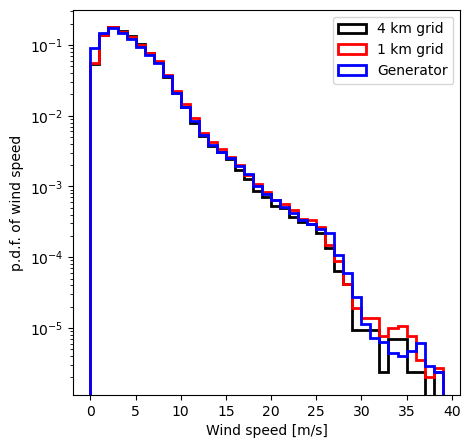

In [32]:
compare_distributions()